# Ćwiczenie 4 - Przecinanie się odcinków

## Konfiguracja środowiska graficznego

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

## Interfejsy

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


### Funkcja wyznaczająca wyznacznik dla 3 punktów

In [3]:
eps = 10**(-12)

# <0 -> p3 po prawej

def det(p1, p2, p3):
    d = (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])
    if abs(d)<eps:
        return 0
    else: 
        return d

In [4]:
import random

def random_lines(lower_left, upper_right, n):
    
    lines = []
    
    # tu znajdują współrzędne x końców odcinków -> żadna para odcinków nie powinn mieć końcwó odcinków o tej samej współrzędnej x
    xs = set()
    
    for i in range(n):
        
        
        x1 = random.randint(lower_left[0], upper_right[0])
        y1 = random.randint(lower_left[1], upper_right[1])
        
        x2 = random.randint(lower_left[0], upper_right[0])
        y2 = random.randint(lower_left[1], upper_right[1])
        
        # sprawdzam czy odcinek nie jest pionowy, lub kończy się w tym samej współrzędnej x co jakiś inny
        while x1==x2 or x2 in xs:
            x1 = random.randint(lower_left[0], upper_right[0])
            y1 = random.randint(lower_left[1], upper_right[1])
        
            x2 = random.randint(lower_left[0], upper_right[0])
            y2 = random.randint(lower_left[1], upper_right[1])
        
        lines.append([(x1,y1),(x2,y2)])
        xs.add(x2)
        
    return lines
    
    
    

### Funkcje konwertujące zadane figury i linie

In [5]:
# potrzebna do konwersji figury zadanej przez rysowanie
def figure_to_lines(figure):
    res = []
    for i in figure:
        res+=i.lines
    return res

def lines_to_points(lines):
    res = []
    for i in range(len(lines)):
        res.append(lines[i][0])
    
    return res

### Założenia:
- Żaden odcinek nie jest pionowy
- dwa odcinki przecinają się w co najwyżej jednym punkcie
- żadne trzy odcinki nie przecinają się w jednym punkcie
- żadne dwa odcinki nie zaczynają się na tej samej współrzędnej x

# Własne odcinki


### Zadaj odcinki
Spełniające założenia



<IPython.core.display.Javascript object>


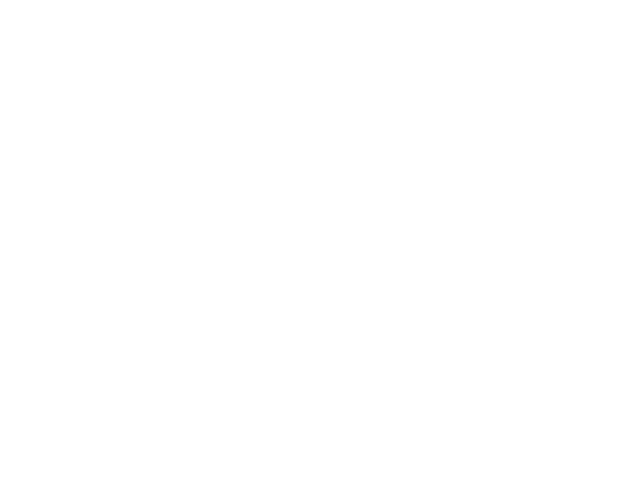

In [6]:
%matplotlib notebook

plot1 = Plot()
plot1.draw()

### Zapisz odcinki do pliku

In [23]:
plot2 = Plot([plot1.get_added_elements()])
with open('somefile.json', 'w') as file:
    file.write(plot2.toJson())

### Wyrysuj zadane odcinki


In [24]:
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

<IPython.core.display.Javascript object>

[[(66, 40), (77, 33)], [(91, 96), (18, 44)], [(65, 75), (53, 85)], [(53, 97), (91, 94)], [(38, 59), (46, 49)], [(94, 71), (75, 75)], [(17, 98), (7, 21)], [(46, 52), (6, 50)], [(65, 100), (10, 100)], [(78, 52), (41, 48)]]


<IPython.core.display.Javascript object>


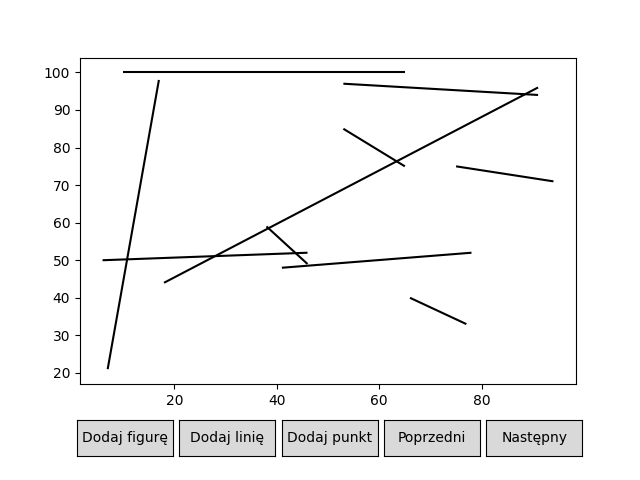

In [26]:
lines1 = random_lines((0,0),(100,100),10)
points1 = []
print(lines1)
scene = [Scene([PointsCollection(points1, color='red')], [LinesCollection(lines1, color='black')])]
plot = Plot(scene)
plot.draw()

# Znajdowanie 1 punktu przecięcia

In [27]:
from tree import RBTree
from queue import PriorityQueue

# T
class State:
    
    def __init__(self):
        
        self.tree = RBTree()
        
    def get_next_segment(self,key):
        return self.tree.successor(key)

    
    def get_prev_segment(self,key):
        return self.tree.predecessor(key)

    
    def insert_segment(self, key):
        
        self.tree.insert(key)
        
    def remove_segment(self,key):
        
        self.tree.remove(key)

    def is_empty(self):
        return self.tree.is_empty()
    
    def get_value(self,key):
        return self.tree.get(key)
    
    def traverse(self):
        return self.tree.nodes()
        

# w kasie State przechowuję StateSegment na których jest zdefiniowany porządek
# na początku jak wrzucam odcinek do drzewa punktem wg którego ustalamy porządek jest jego początek

        
class StateSegment:
    def __init__(self, segment):
        self.segment = segment
        self.start = segment[0]
        self.orientation_point = self.start
    # <
    def __lt__(self, other):
        
        return self.orientation_point[1] < other.orientation_point[1]  
        
    # ==
    def __eq__(self, other):
        
        return (self.segment[0][0] == other.segment[0][0] and self.segment[0][1] == other.segment[0][1] and
               self.segment[1][0] == other.segment[1][0] and self.segment[1][1] == other.segment[1][1]) 
    

    # <=
    def __le__(self, other):
        return self < other and self == other        



def det2(a,b):
    return a[0]*b[1]-a[1]*b[0]

    


def find_crossing_point(segment_1, segment_2):
    # y = ax + b
    (x1,y1),(x2,y2) = segment_1
    a1 = (y2-y1)/(x2-x1)
    # b = y - ax
    b1 = y1 - a1*x1
    
    (x3,y3),(x4,y4) = segment_2
    a2 = (y4-y3)/(x4-x3)
    b2 = y3 - a2*x3
    
    
    p1, p2 = segment_1
    p3, p4 = segment_2
    
    orientation_p3 = det(p1,p2,p3)
    if orientation_p3==0:
        # punkt p3 leży na prostej
        return p3
    
    orientation_p4 = det(p1,p2,p4)
    if orientation_p4==0:
        return p4
    
    if (orientation_p3 < 0 and orientation_p4>0) or (orientation_p3 > 0 and orientation_p4 < 0):
        W = det2((-a1, -a2),(1,1))
        Wx = det2((b1,b2),(1,1))
        Wy = det2((-a1,-a2),(b1,b2))
        
        x = Wx/W
        y = Wy/W
        
        # trzeba jeszcze sprawdzić czy punkt (x,y) zawiera się w obu odcinkach
        if inside_segment(x,x1,x2) and inside_segment(x,x3,x4):
            if inside_segment(y,y1,y2) and inside_segment(y,y3,y4):
                return (x,y)
        
    return None
    
    

def inside_segment(x, x1, x2):
    if x1<x2:
        return x>= x1 and x <= x2
    else:
        return x >= x2 and x <= x1



def process_segments(state_segment, Q, T, results):
    neighbor_1 = T.get_prev_segment(state_segment)
    neighbor_2 = T.get_next_segment(state_segment)
    if neighbor_1 is not None:                
        crossing_point = find_crossing_point(neighbor_1.segment, state_segment.segment)
        if crossing_point is not None:
            Q.put((crossing_point[0],[neighbor_1, state_segment]))
            results.append(crossing_point)


    if neighbor_2 is not None : 
        crossing_point = find_crossing_point(neighbor_2.segment, state_segment.segment)
        if crossing_point is not None:
            Q.put((crossing_point[0],[neighbor_2, state_segment]))
            results.append(crossing_point)

            
def get_y(segment, x):
    (x1, y1), (x2, y2) = segment
    a = (y1-y2)/(x1-x2)
    b = y1-a*x1
    return a*x + b
            
def get_segments_from_T(T):
    s = T.traverse()
    t = []
    for i in s:
        t.append(i.segment)
    return t


def sort_segments(segments):
    for i in range(len(segments)):
        if segments[i][0][0] > segments[i][1][0]:
            segments[i][0], segments[i][1] = segments[i][1], segments[i][0]

            
def find_one_intersection(segments):
    # struktura zdarzeń to kolejka priorytetowa
    Q = PriorityQueue()
    
    results = []
    scenes = []
    scenes.append(Scene([PointsCollection([], color='red')],[LinesCollection(segments,color = 'black' )]))
    
    sort_segments(segments)
    
    T = State()
    
    # potrzebne do wizualizacji miotły
    y_min = min(segments, key=lambda segments: segments[0][1])[0][1]
    y_max = max(segments, key=lambda segments: segments[0][1])[0][1]
    
    y_min_2 = min(segments, key=lambda segments: segments[1][1])[1][1]
    y_max_2 = max(segments, key=lambda segments: segments[1][1])[1][1]
    
    y_min=min(y_min, y_min_2)
    y_max=max(y_max, y_max_2)
    
    # do wizualizacji
    events = []
    
    for segment in segments:
        Q.put((segment[0][0], segment))
        Q.put((segment[1][0], segment))
        
        events.append(segment[0])
        events.append(segment[1])
        
        
        
    # do wizualizacji punktów znajdujących się aktuanie w strukturze stanu
    T_elements = []
    
    while not Q.empty() and len(results)==0:
        x, segment = Q.get()

        
        broom = [[(x,y_min),(x,y_max)]]
        br = broom[:]
        T_elements = get_segments_from_T(T)
        T_e = T_elements[:]
        r = results[:]
        scenes.append(Scene([PointsCollection(r, color='red'), PointsCollection(events, color='green')],[LinesCollection(segments,color = 'black' ), 
                                                                LinesCollection(br, color='red'),
                                                                LinesCollection(T_e, color='orange')]))
        
        
        # jeśli x jest lewym końcem odcinka
        if x == segment[0][0]:
            state_segment = StateSegment(segment) 
            state_segment.orientation_point = (x,get_y(segment,x))
            
            # dodaję odcinek do T
            T.insert_segment(state_segment)
            
            process_segments(state_segment, Q, T, results)
            
        # jeśli y jest prawym końcem odcinka
        elif x == segment[1][0]:            
            state_segment = StateSegment(segment)
            state_segment.orientation_point = (x,get_y(segment,x))
            
            neighbor_1 = T.get_prev_segment(state_segment)
            neighbor_2 = T.get_next_segment(state_segment)
            
            # jeśli rozważany odcinek ma obu sąsiadów w strukturze stanu -> sprawdzam czy się nie przecinają
            if neighbor_1 is not None and neighbor_2 is not None:
                
                crossing_point = find_crossing_point(neighbor_1.segment, neighbor_2.segment)
                
                if crossing_point is not None:
                    results.append(crossing_point)
            
            T.remove_segment(state_segment)
        
            
    r = results[:]
    scenes.append(Scene([PointsCollection(r, color='red')],[LinesCollection(segments,color = 'black' )]))
    
    
    return results, scenes

In [28]:
segments5 = [[(-0.040385081998763554, -0.04618156994090361), (0.0481028212270429, -0.003718334646785948)], [(-0.03306653361166678, -0.017872746411491836), (0.03169153090446225, 0.015828233980665032)], [(-0.05236088845037646, 0.0036958810394885633), (0.04388911154962355, 0.05087725358850817)], [(-0.04726008199876355, 0.02560151829439053), (0.005965724452849347, -0.04281147190168792)], [(-0.025526211031021616, 0.03975593005909642), (0.034574595420591284, -0.03640828562717812)], [(-0.019981856192311943, 0.03537480260811603), (-0.026191533611666783, -0.005403383666393799)]]

points, scenes = find_one_intersection(segments5)
print(points)


plot = Plot(scenes)
plot.draw()


[(-0.03633082115485132, 0.011553757164745982)]


<IPython.core.display.Javascript object>

In [29]:
segments6 = [[(-0.03949798522457001, -0.04078941307815851), (0.04011895025930097, -0.03640828562717812)],
             [(-0.02330846909553775, -0.02056882484286439), (-0.009780243289086138, -0.028657060136982035)], 
             [(-0.010002017482634518, -0.01888377582325655), (0.008183466388333227, -0.013491618960511445)], 
             [(-0.04060685619231194, 0.009762057510076791), (0.03280040187220419, 0.009762057510076791)],
             [(0.020602821227042906, -0.019894805235021254), (0.049655240581881616, 0.01919833201988072)], 
             [(-0.026191533611666783, 0.04717014574537093), (-0.019981856192311943, 0.024253479078704246)],
             [(-0.04969959812779581, -0.005403383666393799), (-0.03883266264392485, -0.024612942489923212)],
             [(0.048546369614139676, 0.0505402437845866), (-0.0009092755471506453, 0.028297596725763083)]]

points, scenes = find_one_intersection(segments6)
print(points)


plot = Plot(scenes)
plot.draw()

[]


<IPython.core.display.Javascript object>

# Znajdowanie wszystkich punktów przecięcia

In [30]:
from tree import RBTree
from queue import PriorityQueue

# T
class State:
    
    def __init__(self):
        
        self.tree = RBTree()
        
    def get_next_segment(self,key):
        return self.tree.successor(key)

    
    def get_prev_segment(self,key):
        return self.tree.predecessor(key)

    
    def insert_segment(self, key):
        
        self.tree.insert(key)
        
    def remove_segment(self,key):
        
        self.tree.remove(key)

    def is_empty(self):
        return self.tree.is_empty()
    
    def get_value(self,key):
        return self.tree.get(key)
    
    def traverse(self):
        return self.tree.nodes()
        

# w kasie State przechowuję StateSegment na których jest zdefiniowany porządek
# na początku jak wrzucam odcinek do drzewa punktem wg którego ustalamy porządek jest jego początek

# jeśli w zdarzeniu, które jest punktem przecięcia dwóch odcinków muszę zmienić ich kolejność to jako 
# orientation_point ustawiam punkt przecięcia danego odcinka z miotłą
        
class StateSegment:
    def __init__(self, segment):
        self.segment = segment
        self.start = segment[0]
        self.orientation_point = self.start
    # <
    def __lt__(self, other):
        
        #return self.orientation_point[1] < other.orientation_point[1]  -> to już nie zadziała, bo mam punkty przecięcia

        orientation = None
        
        if self.orientation_point[0] >= other.orientation_point[0]:
            orientation = orientation_to_segment(self.orientation_point, other.segment)
        else:
            orientation = -orientation_to_segment(other.orientation_point, self.segment)
        
        # nie przecinają się 
        # self.orientation.point jest po lewej other.segment
        # lub other.orientation.point jest po prawej self.segment
        
        if orientation ==1: # -> self < other
            return True
        
        # przecinają się i self.start znajduje się po prawej other.segment -> self < other
        # nie wystarcza orientation_point, bo oba mają takie sam jeśli jest to punkt przecięcia ich obu
        return orientation == 0 and orientation_to_segment(self.start, other.segment) == -1

        
        
    # ==
    def __eq__(self, other):
        return (self.segment[0][0] == other.segment[0][0] and self.segment[0][1] == other.segment[0][1] and
               self.segment[1][0] == other.segment[1][0] and self.segment[1][1] == other.segment[1][1]) 
    

    # <=
    def __le__(self, other):
        return self < other and self == other        

    
# korzystam z równania prostej dla odcinka, a następnie zwracam punkt y dla x
def get_y(segment, x):
    (x1, y1), (x2, y2) = segment
    a = (y1-y2)/(x1-x2)
    b = y1-a*x1
    return a*x + b


def det2(a,b):
    return a[0]*b[1]-a[1]*b[0]


# zwraca informację po której stronie odcinka znajduje się punkt
# -1 -> punkt po prawej
# 0 -> współliniowe
# 1 -> punkt po lewej
def orientation_to_segment(point, segment):
    orientation = det(segment[0], segment[1], point)
    if orientation < 0:
        return -1
    elif orientation > 0:
        return 1
    else:
        return 0

    


def find_crossing_point(segment_1, segment_2):
    # y = ax + b
    (x1,y1),(x2,y2) = segment_1
    a1 = (y2-y1)/(x2-x1)
    # b = y - ax
    b1 = y1 - a1*x1
    
    (x3,y3),(x4,y4) = segment_2
    a2 = (y4-y3)/(x4-x3)
    b2 = y3 - a2*x3
    
    
    p1, p2 = segment_1
    p3, p4 = segment_2
    
    orientation_p3 = det(p1,p2,p3)
    if orientation_p3==0:
        # punkt p3 leży na prostej
        return p3
    
    orientation_p4 = det(p1,p2,p4)
    if orientation_p4==0:
        return p4
    
    if (orientation_p3 < 0 and orientation_p4>0) or (orientation_p3 > 0 and orientation_p4 < 0):
        W = det2((-a1, -a2),(1,1))
        Wx = det2((b1,b2),(1,1))
        Wy = det2((-a1,-a2),(b1,b2))
        
        x = Wx/W
        y = Wy/W
        
        # trzeba jeszcze sprawdzić czy punkt (x,y) zawiera się w obu odcinkach
        if inside_segment(x,x1,x2) and inside_segment(x,x3,x4):
            if inside_segment(y,y1,y2) and inside_segment(y,y3,y4):
                return (x,y)
        
    return None
    
    

def inside_segment(x, x1, x2):
    if x1<x2:
        return x>= x1 and x <= x2
    else:
        return x >= x2 and x <= x1



def process_segments(state_segment, Q, T, added_points, results):
    neighbor_1 = T.get_prev_segment(state_segment)
    neighbor_2 = T.get_next_segment(state_segment)
    if neighbor_1 is not None:                
        crossing_point = find_crossing_point(neighbor_1.segment, state_segment.segment)
        if crossing_point is not None and crossing_point[0] not in added_points:
            Q.put((crossing_point[0],[neighbor_1, state_segment]))
            results.append(crossing_point)
            added_points.add(crossing_point[0])

    if neighbor_2 is not None : 
        crossing_point = find_crossing_point(neighbor_2.segment, state_segment.segment)
        if crossing_point is not None and crossing_point[0] not in added_points:
            Q.put((crossing_point[0],[neighbor_2, state_segment]))
            results.append(crossing_point)
            added_points.add(crossing_point[0])

            
def get_segments_from_T(T):
    s = T.traverse()
    t = []
    for i in s:
        t.append(i.segment)
    return t
            
    
def sort_segments(segments):
    for i in range(len(segments)):
        if segments[i][0][0] > segments[i][1][0]:
            segments[i][0], segments[i][1] = segments[i][1], segments[i][0]
            
    

def find_intersections(segments):
    # struktura zdarzeń to kolejka priorytetowa, żeby uniknąć dodawania duplikatów do Q, będę dodatkowo potrzebować
    # zbioru punktów, które już zostały dodane -> zanim umieszczę punkt w kolejce, sprawdzę czy jest w zbiorze
    Q = PriorityQueue()
    added_points = set()
    
    results = []
    scenes = []
    scenes.append(Scene([PointsCollection([], color='red')],[LinesCollection(segments,color = 'black' )]))
    
    T = State()
    
    
    # trzeba jeszcze poodwracać odcinki tak, żeby początek odcinka był zawsze po lewej stronie !!!
    # 
    
    sort_segments(segments)
    
    
    # potrzebne do wizualizacji miotły
    y_min = min(segments, key=lambda segments: segments[0][1])[0][1]
    y_max = max(segments, key=lambda segments: segments[0][1])[0][1]
    
    y_min_2 = min(segments, key=lambda segments: segments[1][1])[1][1]
    y_max_2 = max(segments, key=lambda segments: segments[1][1])[1][1]
    
    y_min=min(y_min, y_min_2)
    y_max=max(y_max, y_max_2)
    
    # do wizualizacji
    events = []
    
    for segment in segments:
        Q.put((segment[0][0], segment))
        Q.put((segment[1][0], segment))
        added_points.add(segment[0][0])
        added_points.add(segment[1][0])
        events.append(segment[0])
        events.append(segment[1])
        
        
        
    # do wizualizacji punktów znajdujących się aktuanie w strukturze stanu
    T_elements = []
    
    while not Q.empty():
        x, segment = Q.get()

        
        broom = [[(x,y_min),(x,y_max)]]
        br = broom[:]
        T_elements = get_segments_from_T(T)
        T_e = T_elements[:]
        r = results[:]
        scenes.append(Scene([PointsCollection(r, color='red'), PointsCollection(events, color='green')],[LinesCollection(segments,color = 'black' ), 
                                                                LinesCollection(br, color='red'),
                                                                LinesCollection(T_e, color='orange')]))
        
        
        # jeśli x jest lewym końcem odcinka
        if type(segment[0]) is not StateSegment and x == segment[0][0]:
            state_segment = StateSegment(segment) 
            state_segment.orientation_point = (x,get_y(segment,x))
            
            # dodaję odcinek do T
            T.insert_segment(state_segment)
            
            process_segments(state_segment, Q, T, added_points, results)
            
        # jeśli y jest prawym końcem odcinka
        elif type(segment[0]) is not StateSegment and x == segment[1][0]:            
            state_segment = StateSegment(segment)
            state_segment.orientation_point = (x,get_y(segment,x))
            
            neighbor_1 = T.get_prev_segment(state_segment)
            neighbor_2 = T.get_next_segment(state_segment)
            
            # jeśli rozważany odcinek ma obu sąsiadów w strukturze stanu -> sprawdzam czy się nie przecinają
            if neighbor_1 is not None and neighbor_2 is not None:
                
                crossing_point = find_crossing_point(neighbor_1.segment, neighbor_2.segment)
                
                if crossing_point is not None and crossing_point[0] not in added_points:
                    Q.put((crossing_point[0], [neighbor_1, neighbor_2]))
                    results.append(crossing_point)
                    added_points.add(crossing_point[0])
            
            T.remove_segment(state_segment)
            
    
        # jeśli rozważany punkt zdarzeń jest punktem przecięcia dwóch odcinków -> zmieniam porządek odcinków w T
        else:
            segment_1 = segment[0]
            segment_2 = segment[1]            
            T.remove_segment(segment_1)
            T.remove_segment(segment_2)
            segment_1.orientation_point = (x, get_y(segment_1.segment, x))
            segment_2.orientation_point = (x, get_y(segment_2.segment, x))
            T.insert_segment(segment_1)
            process_segments(segment_1, Q, T, added_points, results)
            T.insert_segment(segment_2)
            process_segments(segment_2, Q, T, added_points, results)
            
    r = results[:]
    scenes.append(Scene([PointsCollection(r, color='red')],[LinesCollection(segments,color = 'black' )]))
    
    
    return results, scenes

In [31]:
segments = [[[0.06973623475601687, 0.757307058359932], [0.7181883999591688, 0.4420477298690021]],
           [[0.8527697519172966, 0.3387712586753676], [0.9903536399523706, 0.09124143384560346]], 
           [[0.7753879494427335, 0.2256827052330771], [0.9316355749210459, 0.5752549935619915]],
           [[0.09294639848787101, 0.1181388753934467], [0.9681757317670593, 0.48908365850768476]],
           [[0.14871403566665042, 0.2584180103985013], [0.4366299099271055, 0.5239433822662305]]]





points, scenes = find_intersections(segments)
print(points)


plot = Plot(scenes)
plot.draw()




[(0.8755784303249671, 0.44983853200842944)]


<IPython.core.display.Javascript object>

In [32]:
segments2 =[[(-0.04371169490198936, -0.04483353586757885), (0.042336692194784836, 0.023579454328499602)], 
            [(-0.026856856192311943, 0.035711807269676085), (0.03590524058188162, -0.031690153514637665)],
            [(-0.01709879167618291, 0.009762052367715282), (-0.013106856192311937, -0.003044320181304322)],
            [(-0.020425404579408717, -0.016861722142088642), (-0.002683469095537752, -0.0033813299852258893)]]
points, scenes = find_intersections(segments2)
print("liczba wykrytych punktów: ", len(points))
print("współrzędne punktów: ",points)
print()


plot = Plot(scenes)
plot.draw()




liczba wykrytych punktów:  1
współrzędne punktów:  [(0.009069075351292668, -0.0028700495117187468)]



<IPython.core.display.Javascript object>

In [33]:
segments4 = [[(-0.04681653361166678, -0.040452403274236944), (0.04566330509801064, 0.011110096725763074)], 
             [(-0.04681653361166678, -0.019894805235021254), (0.036792337356075164, -0.034723236607570276)],
             [(0.023929434130268712, 0.008751028098312089), (0.04544153090446226, -0.005403383666393799)], 
             [(-0.04149395296650549, 0.03166769476497877), (0.03346572445284936, 0.04413705751007682)], 
             [(-0.03262298522457001, 0.043800047706155226), (-0.014215727160053877, 0.02054637123556699)],
             [(0.005965724452849347, 0.04717014574537093), (0.0172762083238171, 0.027960586921841515)], 
             [(-0.009780243289086138, 0.04447406731399839), (0.027477821227042898, -0.04651857974482518)]]

points, scenes = find_intersections(segments4)
print("liczba wykrytych punktów: ", len(points))
print("współrzędne punktów: ",points)
print()


plot = Plot(scenes)
plot.draw()






liczba wykrytych punktów:  7
współrzędne punktów:  [(-0.018843538428165073, -0.024855949125162244), (-0.02516885821386459, 0.034383335164282505), (-0.006893274586120046, 0.037423434714842746), (0.011646902105228084, -0.007855883360140875), (0.010045476352602757, 0.04024115535046102), (0.021540480769447097, -0.032018247219709375), (0.03195782444238081, 0.003468551755897519)]



<IPython.core.display.Javascript object>

liczba wykrytych punktów:  7
współrzędne punktów:  [(-0.016636852258401637, -0.04042007225239732), (-0.013533813373439755, -0.02548796519976212), (-0.010348662758518324, -0.010160728989069934), (-0.005858467467073644, 0.011446501620904886), (0.011633688446068236, -0.008861663027360984), (0.016395016533567768, -0.02215662141874296), (0.021672170272047115, -0.03689190915541599)]



<IPython.core.display.Javascript object>


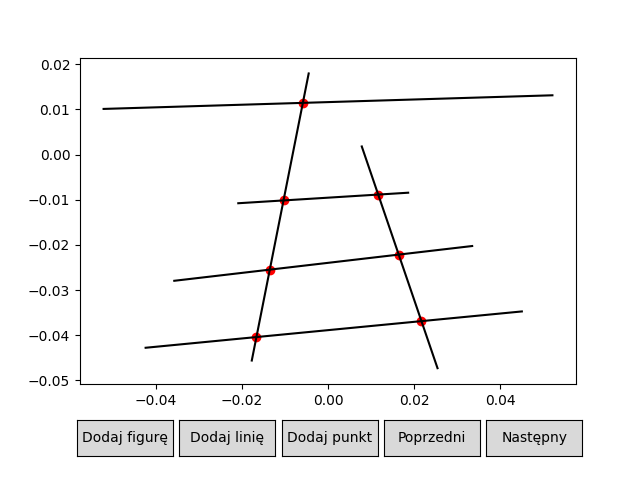

In [34]:
segments5 = [[(-0.04260282393424743, -0.04281147190168792), (0.04521975671091387, -0.034723236607570276)], [(-0.035949598127795815, -0.0279830405291389), (0.03368749864639774, -0.02023181503894282)], [(-0.021090727160053876, -0.010795540529138892), (0.0188286276786558, -0.00843647190168792)], [(-0.004457662643924845, 0.01818730260811602), (-0.01776411425682807, -0.04584456013698204)], [(0.007739918001236454, 0.0020108320198807123), (0.02548185348510741, -0.04752960915658989)], [(-0.05236088845037646, 0.010099067313998372), (0.052316530904462255, 0.013132155549292479)]]

points, scenes = find_intersections(segments5)
print("liczba wykrytych punktów: ", len(points))
print("współrzędne punktów: ",points)
print()


plot = Plot(scenes)
plot.draw()


In [35]:
segments6 = [[(-0.044598791676182914, -0.043755105523502126), (0.05076411154962354, 0.017243668986301808)],
             [(-0.0361713723213442, 0.014210580751007687), (0.04544153090446226, -0.04442912513134527)], 
             [(-0.025747985224570002, -0.014435252582325656), (-0.01776411425682807, -0.015783291798011925)], 
             [(0.028586692194784838, 0.01859170820198809), (0.00884878896897838, -0.043755105523502126)], 
             [(0.039897176065752576, 0.020950776829439063), (0.020824595420591285, -0.04442912513134527)]]


points, scenes = find_intersections(segments6)
print("liczba wykrytych punktów: ", len(points))
print("współrzędne punktów: ",points)
print()


plot = Plot(scenes)
plot.draw()


liczba wykrytych punktów:  5
współrzędne punktów:  [(0.0025391855186418606, -0.01360335107295928), (0.015456118562816904, -0.022884299607736587), (0.02242025027338568, -0.0008864502135352501), (0.025090284227166918, -0.029806546196811605), (0.0360747334066087, 0.007847624667964338)]



<IPython.core.display.Javascript object>

In [36]:
segments7 = [[(-0.01776411425682807, 0.04319342388826261), (-0.04526411425682807, -0.042744076111737424)], 
             [(0.00019959542059128088, 0.03982332584904691), (-0.026635081998763556, -0.045777164347031545)],
             [(0.017719756710913873, 0.0367902376137528), (-0.006231856192311938, -0.04847324277840409)], 
             [(0.03878830509801065, 0.03274611996669398), (0.010401208323817093, -0.04645118395487468)], 
             [(-0.04171572716005388, 0.023983865064733184), (0.04921169219478484, 0.019265727809831226)],
             [(-0.050143146514892586, -0.0009548604254629028), (0.03634878896897839, -0.005335987876443293)], 
             [(-0.046594759418118394, -0.019153389837227613), (0.036792337356075164, -0.025556576111737415)],
             [(-0.053691533611666786, -0.039373978072521736), (0.052538305098010635, -0.0440921153274237)]]

points, scenes = find_intersections(segments7)
print("liczba wykrytych punktów: ", len(points))
print("współrzędne punktów: ",points)
print()


plot = Plot(scenes)
plot.draw()



liczba wykrytych punktów:  16
współrzędne punktów:  [(-0.044318892632850215, -0.039790258536806636), (-0.03792805619257464, -0.019818894660945444), (-0.03218268899312856, -0.0018646221626764396), (-0.024201980015253453, 0.023075093393183282), (-0.025026872123915217, -0.040647102544019154), (-0.018954234175308043, -0.021275869677655136), (-0.013170944665502452, -0.002827635355742468), (-0.005357303027190909, 0.02209726103870945), (-0.004292091586085686, -0.041568025909017516), (0.0009782743270435664, -0.022806460977702735), (0.006313337783500801, -0.0038145843033226975), (0.013320062856320068, 0.021128110298221196), (0.011893828914626802, -0.04228691426888787), (0.018396882235686553, -0.024144013133808116), (0.025338247125172495, -0.004778264351675348), (0.0342350080649427, 0.02004285369605211)]



<IPython.core.display.Javascript object>

In [37]:
segments8 = [[(-0.03572782393424743, -0.0386999584646786), (0.04699395025930096, -0.011739174150953102)],
             [(-0.035949598127795815, -0.018816380033306046), (0.045885079291559036, 0.00039317879022338076)],
             [(-0.037945565869731294, -0.0009548604254629028), (0.04566330509801064, 0.014210580751007687)], 
             [(-0.03683669490198936, 0.01690665918238024), (0.04521975671091387, 0.01387357094708612)],
             [(0.04544153090446226, 0.014210580751007687), (0.025925401872204185, -0.038362948660757026)], 
             [(-0.02397379167618291, -0.007695056503894279), (0.026147176065752578, -0.038362948660757026)]]


points, scenes = find_intersections(segments8)
print("liczba wykrytych punktów: ", len(points))
print("współrzędne punktów: ",points)
print()


plot = Plot(scenes)
plot.draw()

liczba wykrytych punktów:  7
współrzędne punktów:  [(0.0440447728455792, 0.013917002385669636), (-0.014158017468054136, -0.01370110783157328), (0.005002588498094852, -0.025425051400570827), (0.025966451422452325, -0.03825236731884525), (0.03426901635465487, -0.01588650055629431), (0.039780338188493816, -0.001039824760591784), (0.04542552007885059, 0.014167449984152704)]



<IPython.core.display.Javascript object>

In [38]:
segments9 = [[(-0.0412721787729571, -0.0410140931372549), (0.044997982517365476, 0.009537377450980405)], 
             [(0.044997982517365476, 0.009537377450980405), (-0.04726008199876355, 0.00448223039215688)], 
             [(-0.0024616949019893586, -0.044047181372549024), (0.0445544341302687, 0.009537377450980405)], 
             [(0.044776208323817096, 0.009537377450980405), (-0.020647178772957103, 0.046271446078431394)], 
             [(0.00019959542059128088, 0.047282475490196096), (0.0394536276786558, -0.0400030637254902)],
             [(0.04211491800123646, -0.04472120098039216), (-0.022864920708440976, 0.017288602941176484)], 
             [(0.03612701477543, 0.035487132352941195), (-0.019316533611666777, -0.00933517156862744)], 
             [(-0.03683669490198936, 0.03178002450980394), (-0.020425404579408717, -0.04472120098039216)], 
             [(0.018163305098010646, -0.044047181372549024), (-0.014881049740699037, 0.02605085784313728)],
             [(0.03901007929155903, 0.02268075980392159), (0.04189314380768806, -0.005291053921568617)], 
             [(-0.0412721787729571, -0.00933517156862744), (0.039231853485107424, -0.018097426470588235)], 
             [(-0.011110888450376458, 0.04559742647058826), (-0.01842943683747323, 0.006504289215686285)]]

points, scenes = find_intersections(segments9)
print("liczba wykrytych punktów: ", len(points))
print("współrzędne punktów: ",points)
print()


plot = Plot(scenes)
plot.draw()



liczba wykrytych punktów:  33
współrzędne punktów:  [(0.0043215025904712375, -0.014297698870918165), (-0.03116981668055525, 0.005363873182146377), (-0.02769962127606459, -0.010812441776386229), (-0.023459750673980408, -0.030576597464559502), (-0.011498526801281104, 0.00644173302776554), (0.0010493872798361056, 0.007129277810914991), (-0.01738883644773526, 0.012062814173347836), (-0.01190376183382664, 0.04136217292500471), (-0.01480168198433639, 0.025882492501307326), (-0.0008444921884172589, -0.003725337411867628), (-0.005784852382238501, 0.006754805544363251), (-0.006133772745179987, 0.0013221858926519795), (0.010995445780437653, -0.015024107099070403), (-0.004026846270139677, 0.0030254913547286856), (0.04408507075767951, 0.009002441254279488), (0.004129488002542447, -0.01427679953560371), (0.00785011778129509, 0.030270720744962107), (0.020729411144244696, 0.02303922651541629), (0.004178767215668142, -0.01438133709522816), (0.010955036919746376, -0.028756053193364908), (0.007984837906

<IPython.core.display.Javascript object>